<a href="https://colab.research.google.com/github/alruba/ASSIGNMENT/blob/master/Real_NVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Real NVP (Real-valued Non-Volume Preserving)**

It is a type of flow based generative model. When the  data of interest are generally high-dimensional and highly structured, it is a challenge to build  models that  are powerful enough to capture its complexity yet still trainable. This challenge is addressed by Real NVP.It can perform efficient and exact inference, sampling and log-density estimation of data
points.




# ***Model Definition***







1.   *Change of Variable Theorem*


> Generally there occurs the problem of learning highly nonlinear models in high-dimensional continuous spaces through maximum likelihood. In order to optimize the log-likelihood, a more flexible class of architectures that enables the computation of log-likelihood on continuous data is introduced using the change of variable formula.

Given a random variable $z$ and its known probability density function $z \sim \pi(z)$, we would like to construct a new random variable using a 1-1 mapping function $x = f(z)$.
The function $f$ is invertible, so $z=f^{-1}(x)$. Now the question is how to infer the unknown probability density function of the new variable, $p(x)$?
We will calculate the integral as it is used to define the area under the curve, as shown in the figure. 
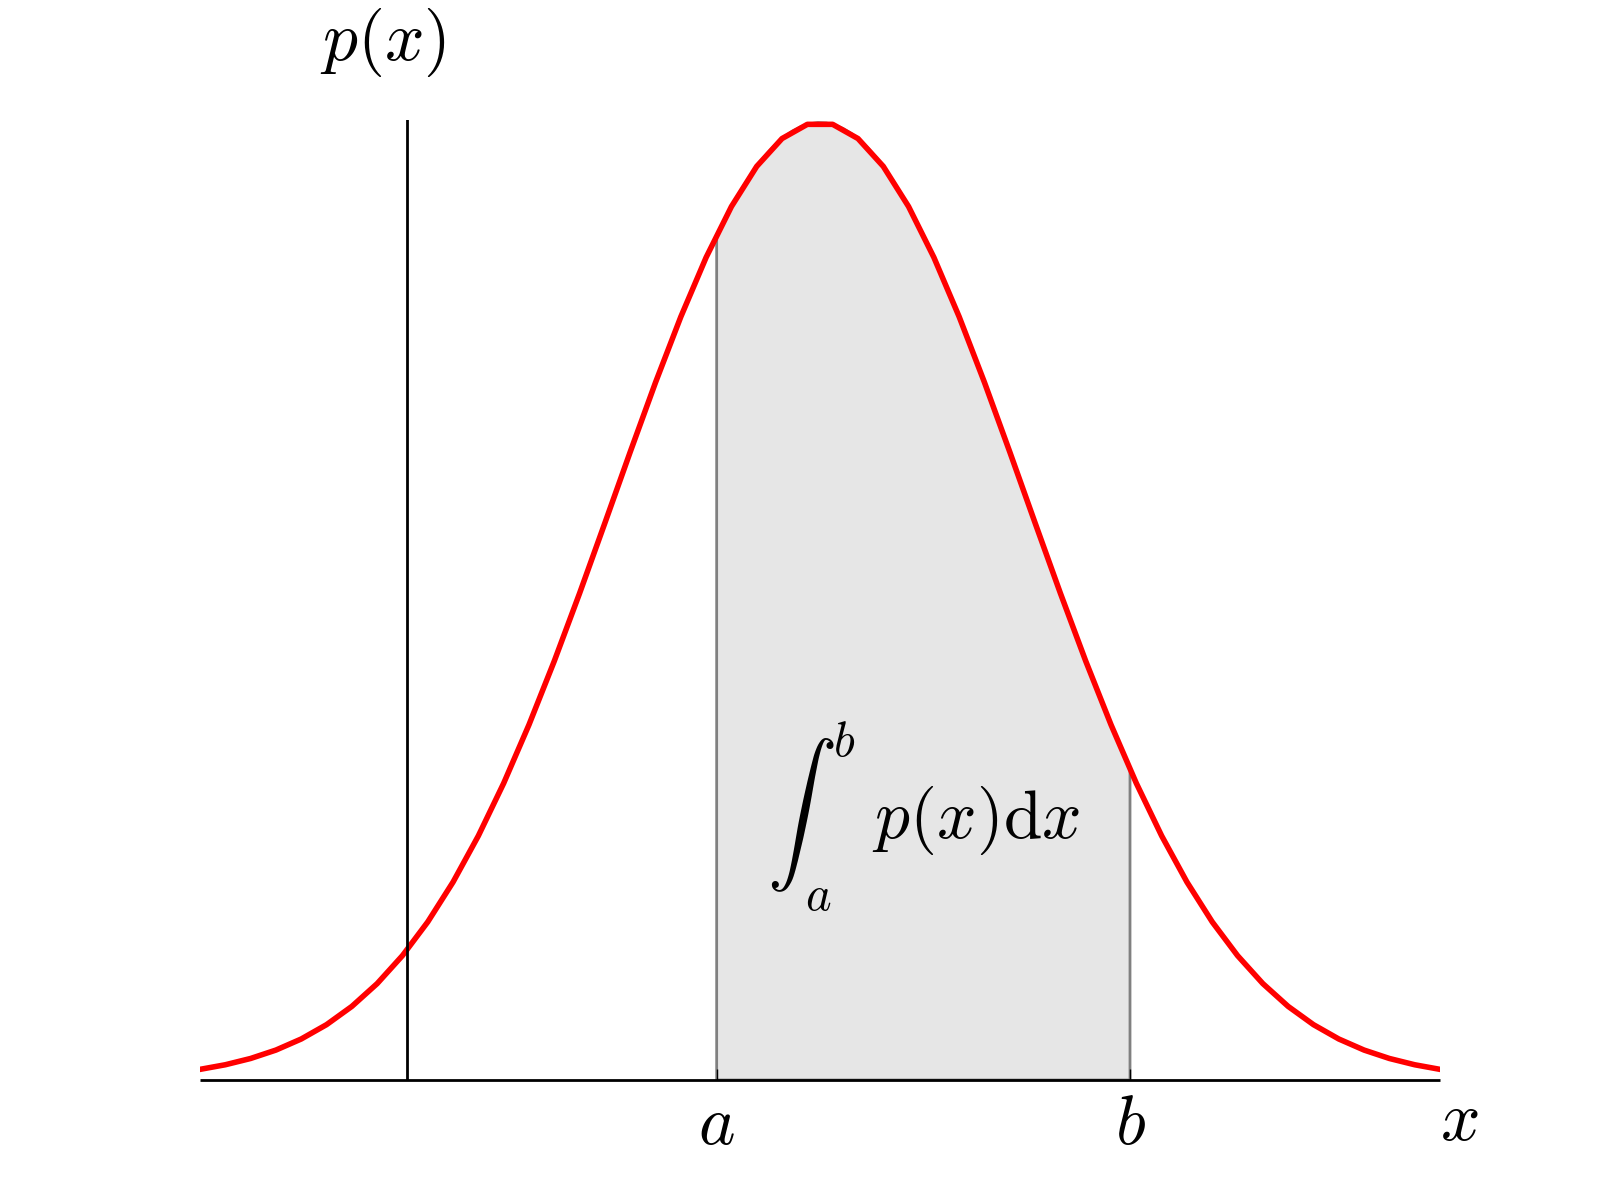

$\begin{aligned}
& \int p(x)dx = \int \pi(z)dz = 1 \scriptstyle{\text{   ; Definition of probability distribution.}}\\
& p(x) = \pi(z) \left\vert\frac{dz}{dx}\right\vert = \pi(f^{-1}(x)) \left\vert\frac{d f^{-1}}{dx}\right\vert = \pi(f^{-1}(x)) \vert (f^{-1})'(x) \vert
\end{aligned}$

By definition, the integral $\int \pi(z)dz$ is the sum of an infinite number of rectangles of infinitesimal width $\Delta z$. The height of such a rectangle at position z is the value of the density function $\pi(z)$. When we substitute the variable, $z = f^{-1}(x)$ yields $\frac{\Delta z}{\Delta x} = (f^{-1}(x))'$ and $\Delta z =  (f^{-1}(x))' \Delta x$

**Note:** Here, definition of probability we mean the second axiom of *Kolmogorov Axioms*, which states that the probability that at least one of the elementary events in the entire sample space will occur is 1. 

2.   *Coupling Layers*


> Computing the Jacobian of functions with high-dimensional domain and codomain and computing the determinants of large matrices are in general computationally very expensive. This combined with the restriction to bijective functions makes Equation  appear impractical for modeling arbitrary
distributions. As computing the Jacobian determinant of the transformation
is crucial to effectively train using this principle, we use Triangular matrix because the determinant of a triangular matrix can be efficiently computed as the product of its diagonal terms.

>>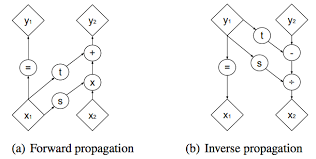



We will build a flexible and tractable bijective function by stacking a sequence of simple bijections.
In each simple bijection, part of the input vector is updated using a function which is simple to invert,
but which depends on the remainder of the input vector in a complex way. We refer to each of these
simple bijections as an $affine coupling layer$. Given a $D$ dimensional input $x$ and $d$ < $D$, the output
$y$ of an affine coupling layer follows the equations


>>>>>$y_{1:d}$ = $x_{1:d}$

>>>>>$y_{d+1:D}$ = $x_{d+1:D}$ $\odot$ $exp(s(x_{1:d}))+t(x_{1:d})$


where $s$ and $t$ stand for scale and translation, and are functions from $R^d$
$\rightarrow$ $R^{D−d}$
, and $\odot$ is the
Hadamard product or element-wise product.

3. *Properties*


The jacobian of this transformation is,
$\mathbf{J} = 
\begin{bmatrix}
  \mathbb{I}_d & \mathbf{0}_{d\times(D-d)} \\[5pt]
  \frac{\partial \mathbf{y}_{d+1:D}}{\partial \mathbf{x}_{1:d}} & \text{diag}(\exp(s(\mathbf{x}_{1:d})))
\end{bmatrix}$
 

 where,   $\text{diag}(\exp(s(\mathbf{x}_{1:d})$  
is the diagonal matrix whose diagonal elements correspond to the vector $\exp(s(\mathbf{x}_{1:d}))$.


Given the observation that this Jacobian is triangular, we can efficiently compute its determinant $\exp(\sum\limits_{j}s(\mathbf{x}_{1:d})_{j})$.



4. *Masked Convolution*


Partitioning can be implemented using a binary mask $b$, and using the functional form for $y$,

$y$ = $b$ $\odot$ $x$ + $(1-b)$ $\odot$ $\bigg(x \odot exp\big(s(b \odot x )\big) + t (b \odot x)\bigg)$


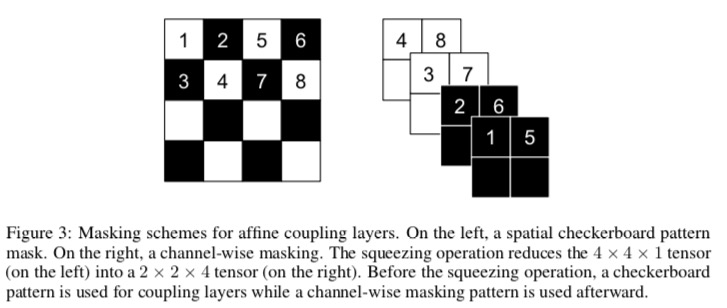


We use two partitionings that exploit the local correlation structure of images: spatial checkerboard patterns, and channel-wise masking. The spatial checkerboard pattern mask has value
$1$ where the sum of spatial coordinates is odd, and $0$ otherwise. The channel-wise mask $b$ is $1$ for the
first half of the channel dimensions and $0$ for the second half 

5. *Combining Coupling Layers*



Although coupling layers can be powerful, their forward transformation leaves some components
unchanged. This difficulty can be overcome by composing coupling layers in an alternating pattern,
such that the components that are left unchanged in one coupling layer are updated in the next. 

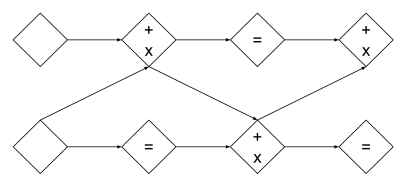


 In this alternating pattern, units which remain identical in one
transformation are modified in the next.

6. *Multi Scale Architecture*

The idea is to implement a multi-scale architecture using a squeezing operation: 
for each channel, it divides the
image into subsquares of shape $2 × 2 × c$, then reshapes them into subsquares 
of shape $1 × 1 × 4c$.
The squeezing operation transforms an $s × s × c$ tensor into an $\frac{s
}{2} ×
s
2 × 4c$ tensor,
effectively trading spatial size for number of channels.

At each scale, we combine several operations into a sequence: we first apply three coupling layers
with alternating checkerboard masks, then perform a squeezing operation, and finally apply three
more coupling layers with alternating channel-wise masking. The channel-wise masking is chosen so
that the resulting partitioning is not redundant with the previous checkerboard masking. For the final scale, we only apply four coupling layers with alternating checkerboard masks.


Propagating a $D$ dimensional vector through all the coupling layers would be cumbersome, in terms
of computational and memory cost, and in terms of the number of parameters that would need to be
trained. For this reason we factor out half of the dimensions at
regular intervals. We can define this operation recursively, as shown in the figure below. 

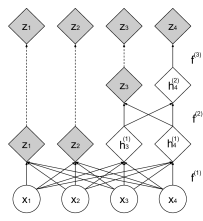



Factoring out variables.
At each step, half the variables are directly modeled as
Gaussians, while the other
half undergo further transformation.


>>>> $h^{(0)} = x$


>>>> $(z^{(i+1)}, h^{(i+1)}) = f^{(i+1)} (h^{(i)})$



>>>>$z^{(L)} = f^{(L)} (h^{(L-1)})$



>>>>$z = (z^{(1)},....,z^{(L)})$

The sequence of coupling-squeezing-coupling
operations described above is performed per layer when computing $f^{(i)}$

 At each
layer, as the spatial resolution is reduced, the number of hidden layer features in $s$ and $t$ is doubled.
All variables which have been factored out at different scales are concatenated to obtain the final
transformed output

7. *Normalizing Flows*

A normalizing flow transforms a simple distribution into a complex one by applying a sequence of invertible transformation functions. Flowing through a chain of transformations, we repeatedly substitute the variable for the new one according to the change of variables theorem and eventually obtain a probability distribution of the final target variable.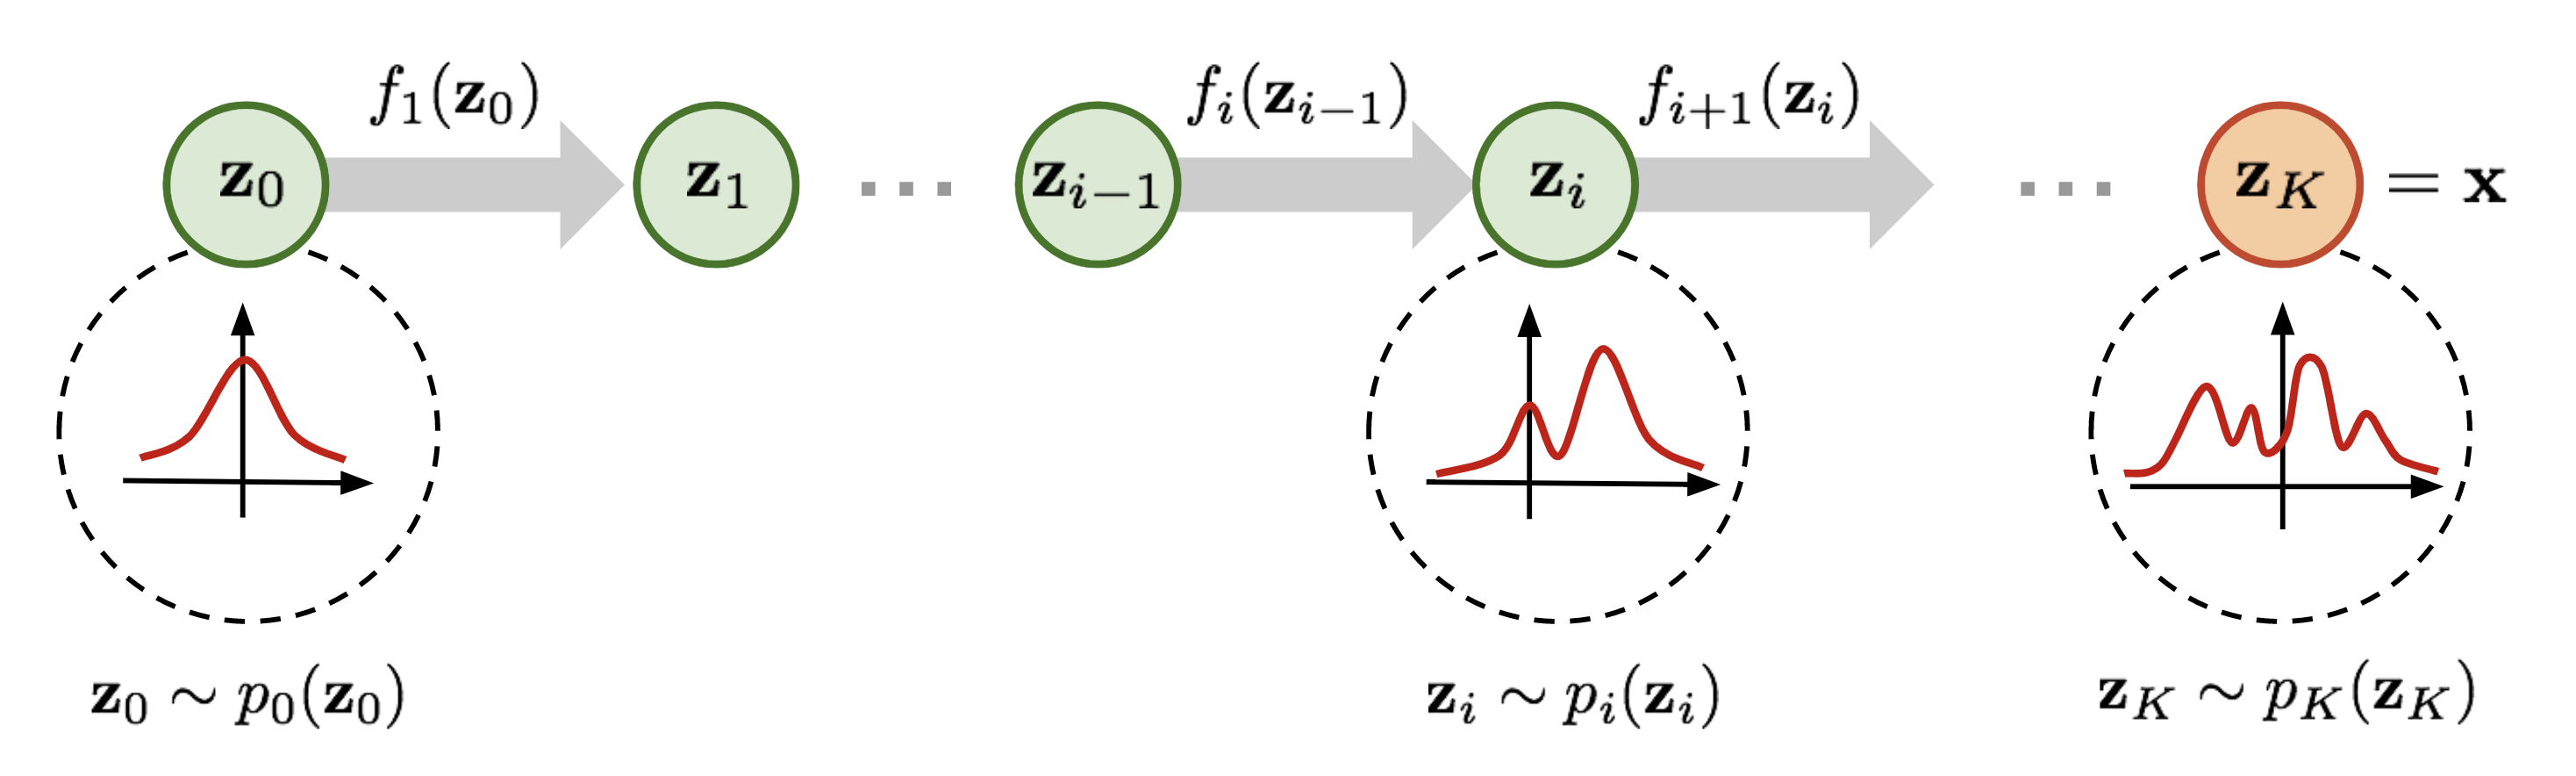. 

$\begin{aligned}
\mathbf{z}_{i-1} &\sim p_{i-1}(\mathbf{z}_{i-1}) \\
\mathbf{z}_i &= f_i(\mathbf{z}_{i-1})\text{, thus }\mathbf{z}_{i-1} = f_i^{-1}(\mathbf{z}_i) \\
p_i(\mathbf{z}_i) 
&= p_{i-1}(f_i^{-1}(\mathbf{z}_i)) \left\vert \det\dfrac{d f_i^{-1}}{d \mathbf{z}_i} \right\vert
\end{aligned}$

So, we can write it as following :

$\begin{aligned}
p_i(\mathbf{z}_i) 
&= p_{i-1}(f_i^{-1}(\mathbf{z}_i)) \left\vert \det\dfrac{d f_i^{-1}}{d \mathbf{z}_i} \right\vert \\
&= p_{i-1}(\mathbf{z}_{i-1}) \left\vert \det \color{red}{\Big(\dfrac{d f_i}{d\mathbf{z}_{i-1}}\Big)^{-1}} \right\vert & \scriptstyle{\text{; According to the inverse func theorem.}} \\
&= p_{i-1}(\mathbf{z}_{i-1}) \color{red}{\left\vert \det \dfrac{d f_i}{d\mathbf{z}_{i-1}} \right\vert^{-1}} & \scriptstyle{\text{; According to a property of Jacobians of invertible func.}} \\
\log p_i(\mathbf{z}_i) &= \log p_{i-1}(\mathbf{z}_{i-1}) - \log \left\vert \det \dfrac{d f_i}{d\mathbf{z}_{i-1}} \right\vert
\end{aligned}$